In [1]:
####### this code is for ATOC 7500 project 3 part II
### GENERAL SETUP
%matplotlib inline  
# this enables plotting within notebook

#import modules
import numpy as np
import matplotlib.pyplot as plt
import numpy as np   # basic math library, type np.$STUFF
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import datetime
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html 

In [2]:
#### Readin data
t1=50  # number of hourly data
t3=73
t5=80
array1=np.loadtxt('E6_SaFra100.txt')
print ('1m/s size:',np.shape(array1))
array3=np.loadtxt('E3_SaFra100.txt')
print ('3m/s size:',np.shape(array3))
array5=np.loadtxt('E8_SaFra100.txt')
print ('5m/s size:',np.shape(array5))

1m/s size: (2550, 51)
3m/s size: (3723, 51)
5m/s size: (4080, 51)


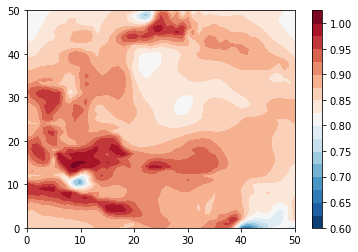

In [3]:
## reshape data to the correct size
D=51  #diameter grid points number
lon=np.arange(0,D,1)
lat=np.arange(0,D,1)
array1_2=np.empty([D,D,t1])
for t in range(t1):
    array1_2[:,:,t]=array1[D*t:D*(t+1),:]
array3_2=np.empty([D,D,t3])
for t in range(t3):
    array3_2[:,:,t]=array3[D*t:D*(t+1),:]
array5_2=np.empty([D,D,t5])
for t in range(t5):
    array5_2[:,:,t]=array5[D*t:D*(t+1),:]
levels=np.arange(0.6,1.05,0.025)
ax=plt.contourf(array5_2[:,:,38],levels,cmap=plt.cm.RdBu_r)
plt.colorbar(ax)

In [5]:
##### Step 1. Prepare data
## 1. cut useful time period
startHour=11
t1end=31
t3end=41
t5end=71
time1=t1end-startHour
time3=t3end-startHour
time5=t5end-startHour
temp1=array1_2[:,:,startHour:t1end]
temp3=array3_2[:,:,startHour:t3end]
temp5=array5_2[:,:,startHour:t5end]

In [6]:
## 2. get anomally, each grid point substract it's own mean through time
anom1=np.empty([D,D,time1])
for t in range(time1):
    anom1[:,:,t]=temp1[:,:,t]-temp1.mean(axis=2)
anom3=np.empty([D,D,time3])
for t in range(time3):
    anom3[:,:,t]=temp3[:,:,t]-temp3.mean(axis=2)
anom5=np.empty([D,D,time5])
for t in range(time5):
    anom5[:,:,t]=temp5[:,:,t]-temp5.mean(axis=2)
## 1-2. connect data
Data_anom=np.concatenate((anom1,anom3,anom5),axis=2)
print('anomaly data size:',np.shape(Data_anom))
Data_ori=np.concatenate((array1_2[:,:,startHour:t1end],array3_2[:,:,startHour:t3end],array5_2[:,:,startHour:t5end]),axis=2)
print('original data size:',np.shape(Data_ori))

anomaly data size: (51, 51, 110)
original data size: (51, 51, 110)


In [7]:
## 3. standardize
Data_stand=np.empty([D,D,time1+time3+time5])
for t in range(time1+time3+time5):
    Data_stand[:,:,t]=(Data_anom[:,:,t]-Data_anom.mean(axis=2))/(Data_anom.std(axis=2));

## 4. resize the data to 2D
a,b,c=np.shape(Data_stand)  ## have axis sizes for later (a, b, c)
data_reshape=np.transpose(Data_stand.reshape(a*b,c))
data_reshape_ori=np.transpose(Data_anom.reshape(a*b,c))
print(a,b,c)
print(np.shape(data_reshape))
print(np.shape(data_reshape_ori))

51 51 110
(110, 2601)
(110, 2601)


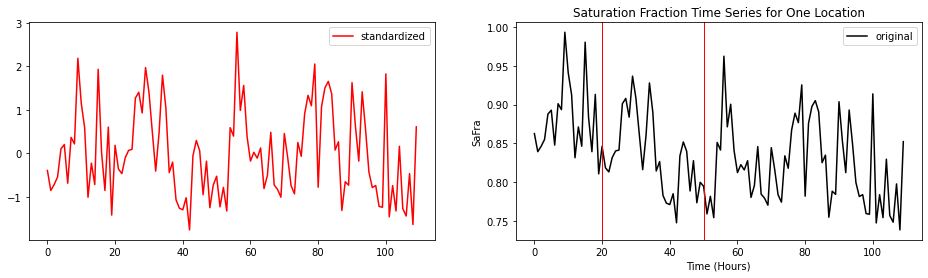

In [9]:
## check data, plot the standardized and original time series for one location
f=plt.figure(figsize=(16,4))
gs=GridSpec(1,2)
plt.subplot(gs[0,0]);
plt.plot(data_reshape[:,2420],label='standardized',color='red');
plt.legend();
plt.subplot(gs[0,1]);
plt.plot(np.transpose(Data_ori.reshape(a*b,c))[:,2420],label='original',color='Black');
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)
plt.xlabel('Time (Hours)')
plt.ylabel('SaFra')
plt.title('Saturation Fraction Time Series for One Location')
plt.legend();

In [19]:
#### Step 2. Calculate EOFs and PCs
## 1. using eigen analysis
# calculate covariance matrix
C = 1./np.size(data_reshape,axis = 0)*np.dot(np.transpose(data_reshape),data_reshape) ## Barnes Chapter 3 Equation 7
print(np.shape(data_reshape))
print(np.shape(C))

#get eigenvalues and eigenvectors - linear algebra module method
lam, E = LA.eig(C) ## Barnes Chapter 3 Equation 42

#order by eigenvalues and eigenvectors by eigenvalues
ii=np.flipud(np.argsort(lam))
lam=lam[ii]
E=E[:,ii]

(110, 2601)
(2601, 2601)


In [20]:
## 2. using SVD
u,s,v=LA.svd(data_reshape)  ## Barnes Chapter 3 Equation (65)

first 3 eigenvalues: 29 %, 14 %, 7 %
total sample size: 110
lag1 autocorrelation from np.correlate: -0.026
effective degree of freedom: [54.]


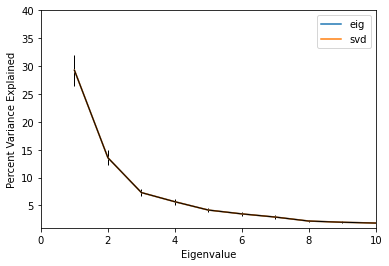

In [77]:
## 3. calculate PCs
# convert eigenvalues to percent variance explained
pve = 100.*np.abs(lam)/np.sum(np.abs(lam))
pve2 = 100.*np.abs(s**2)/np.sum(np.abs(s**2))

print('first 3 eigenvalues:', round(pve[0]),'%,',round(pve[1]),'%,',round(pve[2]),'%')
f=plt.figure()
plt.plot(np.arange(1,len(pve)+1),pve,label='eig');
plt.plot(np.arange(1,len(pve2)+1),pve2,label='svd')
plt.ylim([1,40])
plt.xlim([0,10])
plt.ylabel('Percent Variance Explained')
plt.xlabel('Eigenvalue')
plt.legend()

Nstar = np.size(data_reshape,axis = 0) ## assume all data is independent (not a great assumption)
print("total sample size:",Nstar)
###  could for example - find the effective sample size using the average of all data
###  Caution: Use the data that went into the EOF analysis for this calculation, not the original data...
tseries=np.nanmean(np.nanmean(Data_stand,axis=2),axis=1)
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
N=len(tseries)         ## calculate the length of the timeseries
lag=1
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean
alpha=np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(sigma**2)
print('lag1 autocorrelation from np.correlate:',round(alpha[0],3))
### Calculate the effective sample size (Nstar) for this data
### To estimate the number of independent samples - Chapter 2 Barnes Eq. 88
Nstar=np.round((1-alpha)/(1+alpha)*N,0)
print("effective degree of freedom:",Nstar)
eb = pve*np.sqrt(2./Nstar)  ## North 1982, Barnes Chapter 3 Equation 80
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black');

(2601,)
(110,)
(2601, 2601) (110,) (110, 110)
(51, 51)
(110,)
time length: 110


/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


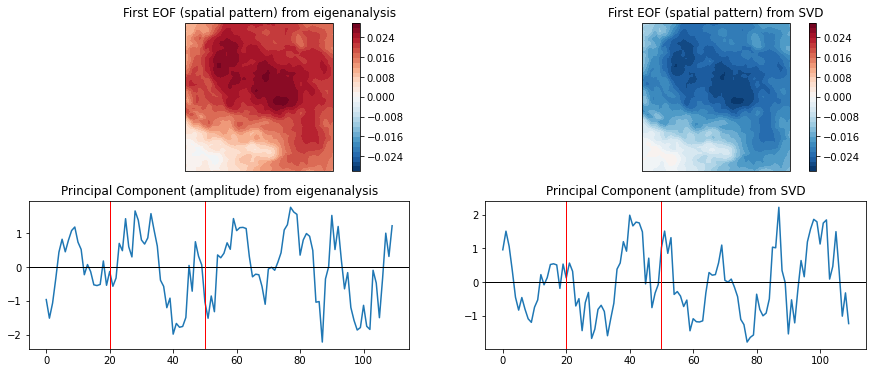

In [73]:
#### Step 3, Plot EOFs and PCs
## 1, first EOF
eof_num=1

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(data_reshape,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(np.shape(z1))

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e1_svd = (v[eof_num-1,:]).reshape(a,b)
print(np.shape(e1_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(np.shape(z1_svd))

### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)
data_time=np.arange(0,time1+time3+time5,1)
print("time length:",len(data_time))

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
levels=np.arange(-0.03,0.031,0.002)
CS=ax.contourf(lon,lat,e1.reshape(a,b)*-1.0,levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.title('First EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(data_time,z1*-1.0)
plt.title('Principal Component (amplitude) from eigenanalysis')
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
levels=levels+1e-14 
CS=ax.contourf(lon,lat,np.real(e1_svd)*-1.0,levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.title('First EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(data_time,z1_svd*-1.0)
plt.title('Principal Component (amplitude) from SVD');
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)

(2601,)
(110,)
(2601, 2601) (110,) (110, 110)
(51, 51)
(110,)
time length: 110


/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


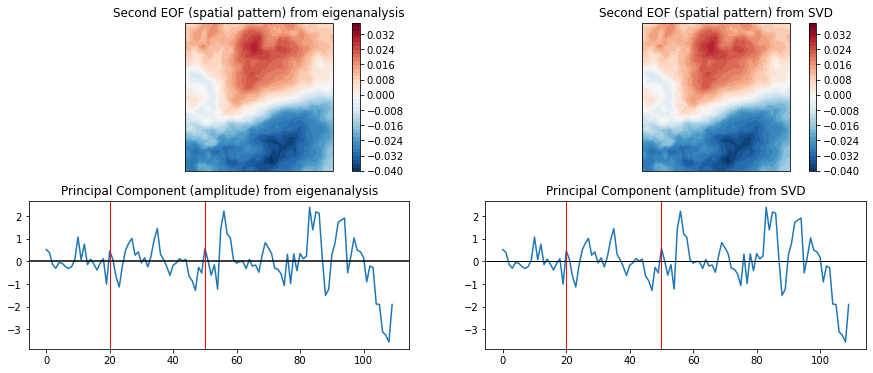

In [76]:
## 2, second EOF
eof_num=2

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e2 = E[:,eof_num-1]
print(np.shape(e2))

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z2 = np.dot(data_reshape,e2)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z2 = (z2-np.mean(z2))/np.std(z2)  
print(np.shape(z2))

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e2_svd = (v[eof_num-1,:]).reshape(a,b)
print(np.shape(e2_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z2_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z2_svd = (z2_svd-np.mean(z2_svd))/np.std(z2_svd)  
print(np.shape(z2_svd))

### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)
data_time=np.arange(0,time1+time3+time5,1)
print("time length:",len(data_time))

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
levels=np.arange(-0.04,0.04,0.002)
CS=ax.contourf(lon,lat,e2.reshape(a,b)*-1,levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.title('Second EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(data_time,z2*-1)
plt.axhline(0.0,color='k')
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)
plt.title('Principal Component (amplitude) from eigenanalysis')
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
levels=levels+1e-14 
CS=ax.contourf(lon,lat,np.real(e2_svd)*-1,levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.title('Second EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(data_time,z2_svd*-1)
plt.title('Principal Component (amplitude) from SVD');
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)

(2601,)
(110,)
(2601, 2601) (110,) (110, 110)
(51, 51)
(110,)
time length: 110


/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


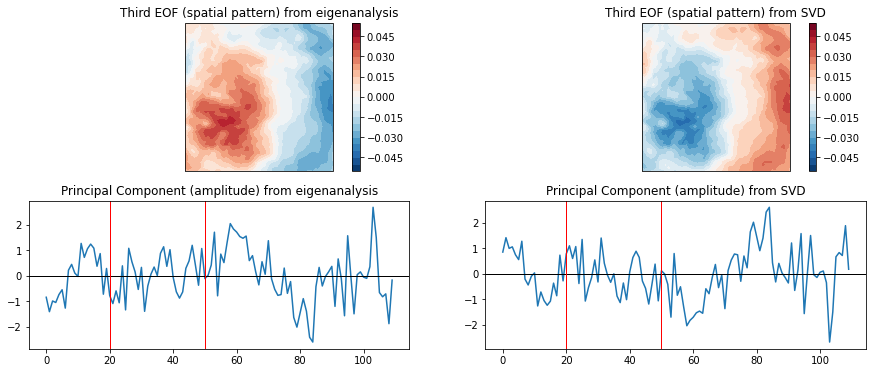

In [43]:
## 3, third EOF
eof_num=3

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e3 = E[:,eof_num-1]
print(np.shape(e3))

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z3 = np.dot(data_reshape,e3)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z3 = (z3-np.mean(z3))/np.std(z3)  
print(np.shape(z3))

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e3_svd = (v[eof_num-1,:]).reshape(a,b)
print(np.shape(e3_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z3_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z3_svd = (z3_svd-np.mean(z3_svd))/np.std(z3_svd)  
print(np.shape(z3_svd))

### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)
data_time=np.arange(0,time1+time3+time5,1)
print("time length:",len(data_time))

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
levels=np.arange(-0.055,0.056,0.005)
CS=ax.contourf(lon,lat,e3.reshape(a,b),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.title('Third EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(data_time,z3)
plt.title('Principal Component (amplitude) from eigenanalysis')
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
levels=levels+1e-14 
CS=ax.contourf(lon,lat,np.real(e3_svd),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
plt.title('Third EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(data_time,z3_svd)
plt.title('Principal Component (amplitude) from SVD');
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)

/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


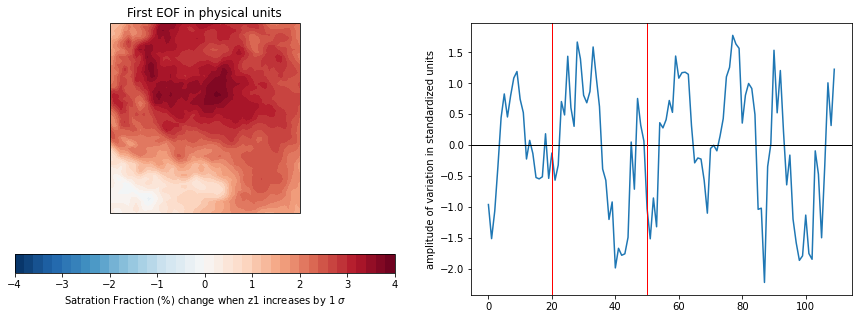

In [71]:
####### Step 4. Regress
# first EOF
d1 = (1./np.size(data_reshape_ori,axis=0))*np.dot(np.transpose(z1),data_reshape_ori)   ## Barnes Chapter 3 Equation (79)
d1plot = d1.reshape(a,b)  ### this is the reshaped eigenvector to plot


f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-4.0,4.1,0.2)
levels2=levels2+1e-14 
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
CS=ax.contourf(lon,lat,d1plot*-100.0,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Satration Fraction (%) change when z1 increases by 1 $\sigma$')
plt.title('First EOF in physical units')
plt.subplot(gs[0,1])
plt.plot(data_time,z1*-1)
plt.ylabel('amplitude of variation in standardized units');
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)

/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


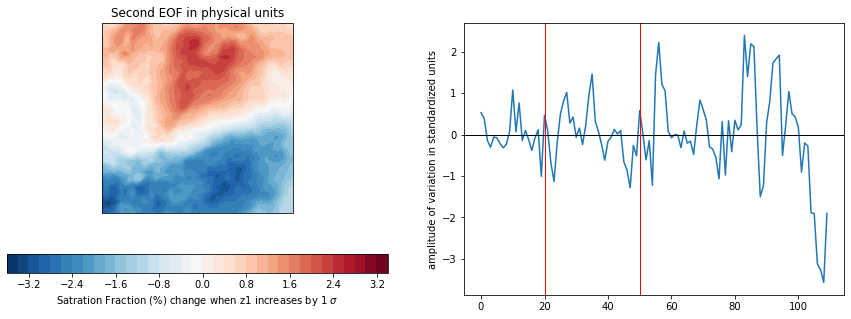

In [66]:
# second EOF
d2 = (1./np.size(data_reshape_ori,axis=0))*np.dot(np.transpose(z2),data_reshape_ori)   ## Barnes Chapter 3 Equation (79)
d2plot = d2.reshape(a,b)  ### this is the reshaped eigenvector to plot


f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-3.6,3.6,0.2)
levels2=levels2+1e-14 
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
CS=ax.contourf(lon,lat,d2plot*-100.0,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Satration Fraction (%) change when z1 increases by 1 $\sigma$')
plt.title('Second EOF in physical units')
plt.subplot(gs[0,1])
plt.plot(data_time,z2*-1)
plt.ylabel('amplitude of variation in standardized units');
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)

/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


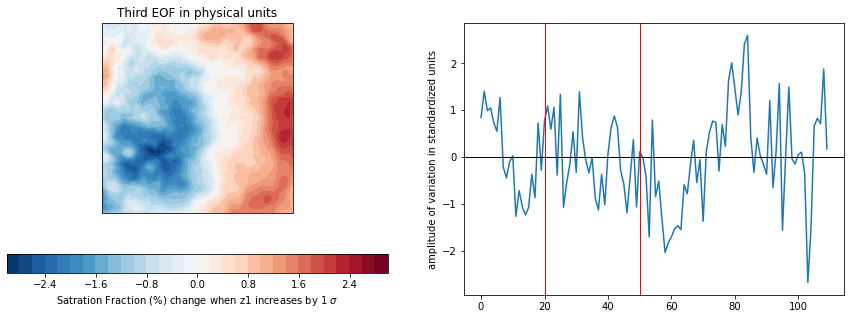

In [70]:
# Third EOF
d3 = (1./np.size(data_reshape_ori,axis=0))*np.dot(np.transpose(z3),data_reshape_ori)   ## Barnes Chapter 3 Equation (79)
d3plot = d3.reshape(a,b)  ### this is the reshaped eigenvector to plot


f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-3.0,3.1,0.2)
levels2=levels2+1e-14 
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
CS=ax.contourf(lon,lat,d3plot*-100.0,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Satration Fraction (%) change when z1 increases by 1 $\sigma$')
plt.title('Third EOF in physical units')
plt.subplot(gs[0,1])
plt.plot(data_time,z3*-1)
plt.ylabel('amplitude of variation in standardized units');
plt.axhline(0.0,color='k',linewidth=1)
plt.axvline(20,color='r',linewidth=1)
plt.axvline(50,color='r',linewidth=1)